<a href="https://colab.research.google.com/github/convin305/kaggle/blob/main/%5BPorto_Seguro%E2%80%99s_Safe_Driver_Prediction3%5DXGBoost_CV_(LB_284).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/aharless/xgboost-cv-lb-284/notebook

참고  
https://lsjsj92.tistory.com/429  
https://colab.research.google.com/drive/1TbMWFhUJ7Kxc6ZluXDvF4C0md8wkDm4U  
https://www.kaggle.com/code/werooring/ch8-baseline?scriptVersionId=89288718

In [ ]:
MAX_ROUNDS = 400
OPTIMIZE_ROUNDS = False
LEARNING_RATE = 0.07
EARLY_STOPPING_ROUNDS = 50 
# 처음에는 Max_Rounds를 높게 설정하고 Optimize_rounds를 사용하여 적절한 라운드 수를 파악할 것

## 패키지 & 데이터 로드 & 함수정의

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from numba import jit
import time
import gc

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

# 데이터셋 다운로드
! kaggle competitions download -c porto-seguro-safe-driver-prediction
!unzip porto-seguro-safe-driver-prediction.zip

Saving kaggle.json to kaggle.json
 85% 65.0M/76.5M [00:02<00:00, 26.0MB/s]
100% 76.5M/76.5M [00:02<00:00, 27.8MB/s]
Archive:  porto-seguro-safe-driver-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


### Numba
[Numba 공식문서](https://numba.pydata.org/)    

파이썬과 넘파이 코드를 빠르게 실행시켜주는 오픈소스 JIT컴파일러  
JIT는 Just in time의 약자.  
프로그램을 실제 실행시키는 그 시점에 기계어로 컴파일하여 인터프리터 속도를 향상시키는 방법.  
numpy나 루프를 많이 사용하고 있는 경우 적용하면 잘 작동하여 속도를 빠르게 할 수 있다.

```
@jit
```

파이썬 펑션에 numba데코레이터 하나만 적용하면 사용가능함.  


```
@jit(int32(int32,int32))
```


와 같이 실행할 함수에 대한 정보를 미리 알려줄 수도 있음  

Numba의 모드는 **nopython**과 **object**모두 두가지  
* nopython : CPython 인터프리터를 사용하지 않는 모드. int, float, complex와 같이 지정된 타입에 대해서만 동작함  
* object : 지정되지 않은 경우 실행되는 디폴트 모드  

nopython에서 먼저 실행되고, 그 다음에 object로 실행됨. 만약 object로 넘어가지 않고 에러로 반환하게 하려면 nopython = True조건을 지정하면 됨






**추가 참고 문서**  
https://data-newbie.tistory.com/390  
https://hongl.tistory.com/204  
https://gurujung.github.io/_posts/2019-02-17-numba_user_5minguide/


### Gini
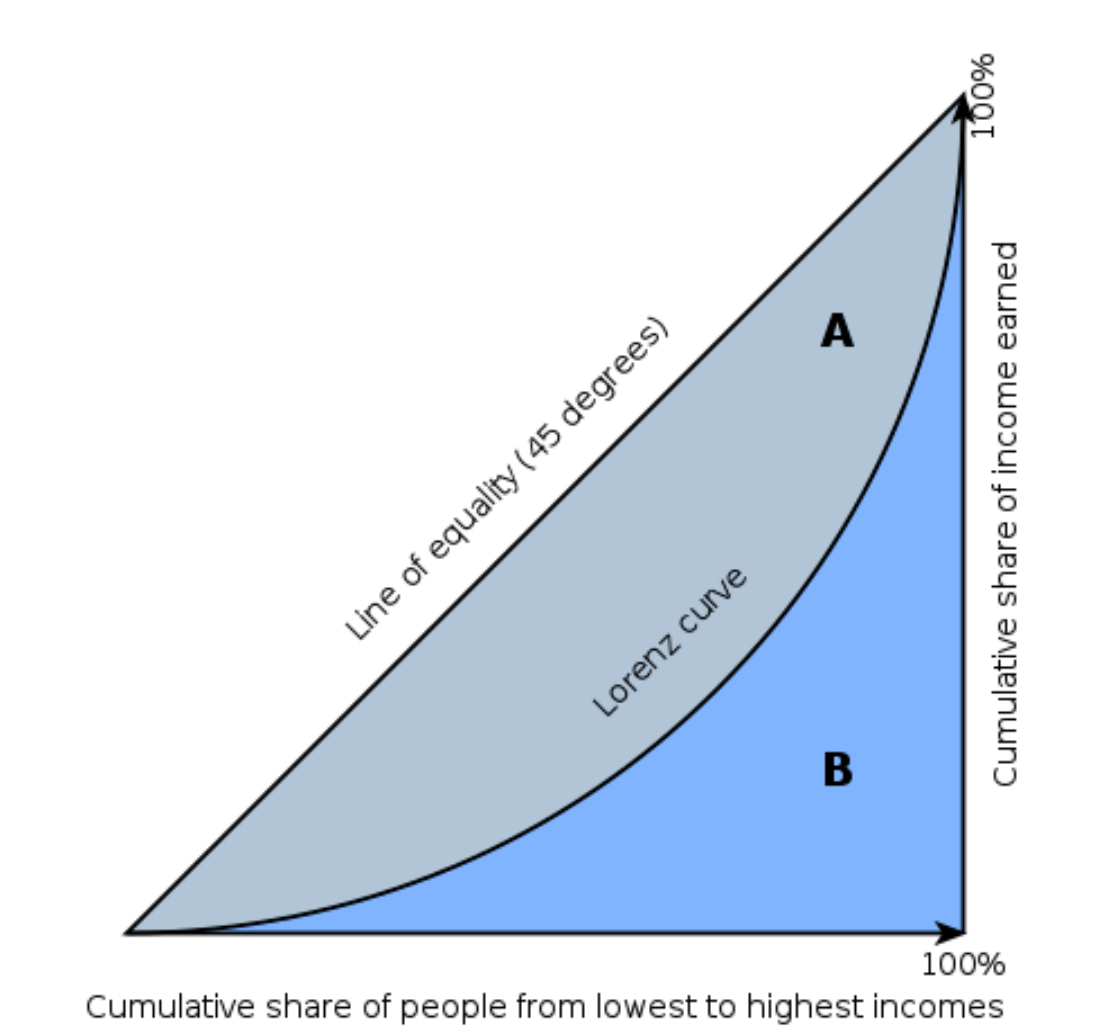  

지니계수 = A / (A + B)  
불순도를 측정하는데 사용되는 지표.  
0과 1 사이의 값을 가지며, 값이 1에 가까울수록 불평등의 정도가 높은 것을 의미하며 0에 가까울수록 이상적  

**참고 문서**  

https://vincenthanna.tistory.com/entry/Gini-coefficient  

S : 이미 발생한 사건의 모음, c : 사건의 갯수  
분할을 하는 경우, 지니지수(불순도)가 더 낮게 나온 쪽으로 분할을 함  


In [ ]:
# Compute gini

# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
@jit
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true) # array저장 http://yochin47.blogspot.com/2016/03/python-numpy-array-vs-asarray.html
    y_true = y_true[np.argsort(y_prob)] 
    # y_prob의 array 오름차순 정렬 순서를 기준으로 y_true를 정렬 https://codetorial.net/tips_and_examples/numpy_argsort.html
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i 
    gini = 1 - 2 * gini / (ntrue * (n - ntrue)) 
    return gini

참고 : https://kubig-2021-2.tistory.com/38

In [ ]:
# Funcitons from olivier's kernel
# https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]


def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))


def target_encode(trn_series=None,    # Revised to encode validation series
                  val_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_val_series = pd.merge(
        val_series.to_frame(val_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=val_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_val_series.index = val_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_val_series, noise_level), add_noise(ft_tst_series, noise_level)

## 데이터 읽기 & 전처리

In [ ]:
# 결측값은 -1로 처리 : na_values = '-1'
train_df = pd.read_csv('train.csv', na_values="-1")
test_df = pd.read_csv('test.csv', na_values="-1")

In [ ]:
train_df.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


In [ ]:
train_features = [
    "ps_car_13",  #          : 1571.65 / shadow 609.23
    "ps_reg_03",  #          : 1408.42 / shadow 511.15
    "ps_ind_05_cat",  #        : 1387.87 / shadow   84.72
    "ps_ind_03",  #            : 1219.47 / shadow  230.55
    "ps_ind_15",  #            :  922.18 / shadow  242.00
  	"ps_reg_02",  #            :  920.65 / shadow  267.50
   	"ps_car_14",  #            :  798.48 / shadow  549.58
	  "ps_car_12",  #            :  731.93 / shadow  293.62
  	"ps_car_01_cat",  #        :  698.07 / shadow  178.72
  	"ps_car_07_cat",  #        :  694.53 / shadow   36.35
  	"ps_ind_17_bin",  #        :  620.77 / shadow   23.15
  	"ps_car_03_cat",  #        :  611.73 / shadow   50.67
  	"ps_reg_01",  #            :  598.60 / shadow  178.57
	  "ps_car_15",  #            :  593.35 / shadow  226.43
	  "ps_ind_01",  #            :  547.32 / shadow  154.58
  	"ps_ind_16_bin",  #        :  475.37 / shadow   34.17
  	"ps_ind_07_bin",  #        :  435.28 / shadow   28.92
  	"ps_car_06_cat",  #        :  398.02 / shadow  212.43
  	"ps_car_04_cat",  #        :  376.87 / shadow   76.98
  	"ps_ind_06_bin",  #        :  370.97 / shadow   36.13
  	"ps_car_09_cat",  #        :  214.12 / shadow   81.38
  	"ps_car_02_cat",  #        :  203.03 / shadow   26.67
  	"ps_ind_02_cat",  #        :  189.47 / shadow   65.68
  	"ps_car_11",  #            :  173.28 / shadow   76.45
  	"ps_car_05_cat",  #        :  172.75 / shadow   62.92
  	"ps_calc_09",  #           :  169.13 / shadow  129.72
  	"ps_calc_05",  #           :  148.83 / shadow  120.68
  	"ps_ind_08_bin",  #        :  140.73 / shadow   27.63
  	"ps_car_08_cat",  #        :  120.87 / shadow   28.82
  	"ps_ind_09_bin",  #        :  113.92 / shadow   27.05
  	"ps_ind_04_cat",  #        :  107.27 / shadow   37.43
  	"ps_ind_18_bin",  #        :   77.42 / shadow   25.97
  	"ps_ind_12_bin",  #        :   39.67 / shadow   15.52
  	"ps_ind_14",  #            :   37.37 / shadow   16.65
]

In [ ]:
combs = [
    ('ps_reg_01', 'ps_car_02_cat'),  
    ('ps_reg_01', 'ps_car_04_cat'),
]

In [ ]:
id_test = test_df['id'].values
id_train = train_df['id'].values
y = train_df['target']

start = time.time()
for n_c, (f1, f2) in enumerate(combs):
    name1 = f1 + "_plus_" + f2
    print('Current Feature %60s %4d in %5.1f'
          % (name1, n_c + 1, (time.time() - start) / 60), end='')
    print('\r' * 75, end='')
    train_df[name1] = train_df[f1].apply(lambda x: str(x)) + "_" + train_df[f2].apply(lambda x: str(x))
    test_df[name1] = test_df[f1].apply(lambda x: str(x)) + "_" + test_df[f2].apply(lambda x: str(x))
    # Label Encode
    lbl = LabelEncoder()
    lbl.fit(list(train_df[name1].values) + list(test_df[name1].values))
    train_df[name1] = lbl.transform(list(train_df[name1].values))
    test_df[name1] = lbl.transform(list(test_df[name1].values))

    train_features.append(name1)
    
X = train_df[train_features]
test_df = test_df[train_features]

f_cats = [f for f in X.columns if "_cat" in f]

In [ ]:
y_valid_pred = 0*y
y_test_pred = 0

In [ ]:
# Set up folds
K = 5
kf = KFold(n_splits = K, random_state = 1, shuffle = True)
np.random.seed(0)

In [ ]:
# Set up classifier
model = XGBClassifier(    
                        n_estimators=MAX_ROUNDS,
                        max_depth=4,
                        objective="binary:logistic",
                        learning_rate=LEARNING_RATE, 
                        subsample=.8,
                        min_child_weight=6,
                        colsample_bytree=.8,
                        scale_pos_weight=1.6,
                        gamma=10,
                        reg_alpha=8,
                        reg_lambda=1.3,
                     )

In [ ]:
# RUN CV

for i, (train_index, test_index) in enumerate(kf.split(train_df)):
    
    # Create data for this fold
    y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
    X_test = test_df.copy()
    print( "\nFold ", i)
    
    # Enocode data
    for f in f_cats:
        X_train[f + "_avg"], X_valid[f + "_avg"], X_test[f + "_avg"] = target_encode(
                                                        trn_series=X_train[f],
                                                        val_series=X_valid[f],
                                                        tst_series=X_test[f],
                                                        target=y_train,
                                                        min_samples_leaf=200,
                                                        smoothing=10,
                                                        noise_level=0
                                                        )
    # Run model for this fold
    if OPTIMIZE_ROUNDS:
        eval_set=[(X_valid,y_valid)]
        fit_model = model.fit( X_train, y_train, 
                               eval_set=eval_set,
                               eval_metric=gini_xgb,
                               early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                               verbose=False
                             )
        print( "  Best N trees = ", model.best_ntree_limit )
        print( "  Best gini = ", model.best_score )
    else:
        fit_model = model.fit( X_train, y_train )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict_proba(X_valid)[:,1]
    print( "  Gini = ", eval_gini(y_valid, pred) )
    y_valid_pred.iloc[test_index] = pred
    
    # Accumulate test set predictions
    y_test_pred += fit_model.predict_proba(X_test)[:,1]
    
    del X_test, X_train, X_valid, y_train
    
y_test_pred /= K  # Average test set predictions

print( "\nGini for full training set:" )
eval_gini(y, y_valid_pred)


Fold  0


<ipython-input-4-96310d67cf27>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "eval_gini" failed type inference due to: non-precise type pyobject
During: typing of argument at <ipython-input-4-96310d67cf27> (6)

File "<ipython-input-4-96310d67cf27>", line 6:
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true) # array저장 http://yochin47.blogspot.com/2016/03/python-numpy-array-vs-asarray.html
    ^

  @jit
<ipython-input-4-96310d67cf27>:4: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "eval_gini" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-4-96310d67cf27>", line 13:
def eval_gini(y_true, y_prob):
    <source elided>
    n = len(y_true)
    for i in range(n-1, -1, -1):
    ^

  @jit
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "eval_

  Gini =  0.2856959531750338

Fold  1
  Gini =  0.2825270426290394

Fold  2
  Gini =  0.2744124272744569

Fold  3
  Gini =  0.29925913576337726

Fold  4
  Gini =  0.28468083823013424

Gini for full training set:


<ipython-input-4-96310d67cf27>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "eval_gini" failed type inference due to: non-precise type pyobject
During: typing of argument at <ipython-input-4-96310d67cf27> (6)

File "<ipython-input-4-96310d67cf27>", line 6:
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true) # array저장 http://yochin47.blogspot.com/2016/03/python-numpy-array-vs-asarray.html
    ^

  @jit
<ipython-input-4-96310d67cf27>:4: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "eval_gini" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-4-96310d67cf27>", line 13:
def eval_gini(y_true, y_prob):
    <source elided>
    n = len(y_true)
    for i in range(n-1, -1, -1):
    ^

  @jit
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "eval_

0.28509183378958614

In [ ]:
# Save validation predictions for stacking/ensembling
val = pd.DataFrame()
val['id'] = id_train
val['target'] = y_valid_pred.values
val.to_csv('xgb_valid.csv', float_format='%.6f', index=False)